In [1]:
import gurobipy as gp
from gurobipy import GRB

import numpy as np
import graspy

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm
sns.set()

In [41]:
def generate_latent_positions(n=50, d=2, acorn=None):
    """
    A function to generate an adjacency matrix.
    
    Input
    n - int
        If P is None then n is the number of latent positions to randomly generate.
    d - int
        If P is None the d is the dimension of the latent positions.
    acorn - int
        Random seed.
        
    Return
    X - np.array (shape=(n,d))
        An array of uniformly distributed points in the positive unit sphere
    """
    
    if acorn is not None:
        np.random.seed(acorn)
        
    mvns = np.random.multivariate_normal(np.zeros(d), np.eye(d), size=n)

    mvns = abs(mvns) / np.linalg.norm(mvns, axis=1)[:, None]

    unis = np.random.uniform(size=n)**(1/d)
    X = mvns * unis[:, None]
                
    return X


def sample_moment(X, k=1):
    """
    Estimate the kth sample moment.
    
    Input
    X - np.array (length=n or shape=(n,d))
        i.i.d. realizations of a random variable.
    k - int (default=1)
        Moment to estimate.
    """
    if X.ndim == 1:
        estimate = np.mean(X**k)
    elif X.ndim == 2:
        n, d = X.shape
        if k == 1:
            estimate = np.mean(X, axis=0)
        elif k == 2:
            estimate = np.mean(np.array([X[i, np.newaxis].T @ X[i, np.newaxis] for i in range(n)]), axis=0)
            
    return estimate
        
    
def ASE_covariance(X, ind):
    x = X[ind]

    # this might break with ind = 0
    X_no_x = np.concatenate((X[:ind], X[ind+1:]))
    
    n, d = X_no_x.shape
    
    covs = np.array([X_no_x[i, np.newaxis].T @ X_no_x[i, np.newaxis] for i in range(n)])
    innards = np.array([x @ X_no_x[i] - x @ covs[i] @ x[:, np.newaxis] for i in range(n)])
    
    delta = np.mean(covs, axis=0)
    delta_inv = np.linalg.pinv(delta)
    
    scaled_covs = np.mean(np.array([covs[i] * innards[i] for i in range(n)]), axis=0)
        
    Sigma_x = delta_inv @ scaled_covs @ delta_inv
    
    return Sigma_x


def LSE_covariance(X, ind):
    x = X[ind]
    
    X_no_x = np.concatenate((X[:ind], X[ind+1:]))
    n, d = X_no_x.shape
    mu = np.mean(X_no_x, axis=0)
    
    denoms = np.array([X_no_x[i] @ mu for i in range(n)])
    
    # could do more succintly
    mu_t = np.mean(np.array([X_no_x[i] / denoms[i] for i in range(n)]), axis=0)
    
    
    covs = np.array([X_no_x[i, np.newaxis].T @ X_no_x[i, np.newaxis] for i in range(n)])
    delta_t = np.mean(np.array([covs[i] / denoms[i] for i in range(n)]), axis=0)
    
    delta_t_inv = np.linalg.pinv(delta_t)
    
    prod11 = np.array([(delta_t_inv @ X_no_x[i, np.newaxis].T) / denoms[i] for i in range(n)])
    prod12 = x[:, np.newaxis].T / (2*x@mu)
    prod = prod11 - prod12.T
    
    prod21 = np.array([(X_no_x[i, np.newaxis] @ delta_t_inv) / denoms[i] for i in range(n)])
    prod22 = x / (2*x@mu)
    prod2 = prod21 - prod22
    prod = prod @ prod2
    
#     print((x @ X_no_x[0]).shape)
#     print(x[:, np.newaxis].shape, covs[0].shape)
    prod3 = np.array([x @ X_no_x[i] - x[:, np.newaxis].T @ covs[i] @ x[:, np.newaxis] for i in range(n)])[0]
#     print(prod3)
    prod3 = prod3 / (x@mu)
    
    prod = prod * prod3[:, np.newaxis]
    
    Sigma_x = np.mean(np.array(prod), axis=0)
        
    return Sigma_x


def identity(X):
    _, d = X.shape
    return np.eye(d)
  

def generate_distance_matrix(A, embedding_functions, covariance_functions, true_covs=None,acorn=None):
    """
    A function to generate a distance matrix given an adjacency matrix. The ith column of the
    distance matrix is the Euclidean distance from the first node in the graph to the other
    nodes in the ith embedding.
    
    Input
    A - list of np.arrays (length=J) or np.array (shape=(n,d[j]))
        Latent positions or adjacency matrix.
    emebedding_functions - 
    
    covariance_functions - 
    covariances - list of np.arrays (length=J, covariances[j].shape=(d[j],d[j]))
        List of covariances to calculate the Mahalonobis distance between vectors in X.
    acorn - int
        Random seed.
        
    Return
    dist_matrix - np.array (shape=(n, J))
        Distance matrix where the ith column is the Euclidean distance from the first node in the graph
        to all of the other nodes in the graph in the ith embedding.
    """
    
    if acorn is not None:
        np.random.seed(acorn)
        
    n = A.shape[0]
        
    J = len(covariance_functions)
            
    dist_matrix = np.zeros((n, J))
    
    if embedding_functions is None:
        embedding_functions = [None for cov in covariance_functions]
    
    for j, embed in enumerate(embedding_functions):
        if embed is None:
            temp_X = A
        else:
            temp_X = embed(A)
            
        if isinstance(covariance_functions[j], np.ndarray):
            temp_cov = covariance_functions[j]
        else:
            temp_cov = covariance_functions[j](temp_X, 0)
            
        # Can probably do the below more succintly?
        dist_matrix[:, j] = np.sqrt(np.array([(temp_X[0] - temp_X[i])[:, np.newaxis].T @ temp_cov @ (temp_X[0] - temp_X[i])[:, np.newaxis] for i in range(n)])[:,0,0])
        if np.sum(dist_matrix[:, j] < 0) > 0:
            print("i broke on distance %i"%(j))
    return dist_matrix  


def generate_S_indices(dist_matrix, alpha, n_inds=1):
    """
    A function to generate the nodes of interest.
    
    Input
    dist_matrix - np.array (shape=(n,J))
        Array containing the distances between the vertex of interest and the other n - 1
        vertices. It is assumed that the vertex of interest is indexed by 0.
    alpha - float or array-like
        Coefficients of the distances to generate the ground truth. alpha can only be an int
        if J == 2. If alpha is array-like then the sum of alpha must be 1.
    n_inds - int or func
        Number of vertices in the vertex set of interest. If n_inds is a function then the
        ceiling of n_inds(n) is used.
        
    Return
    S - np.array (length=n_inds)
        A list of indices of length n_inds in range(1,n) corresponding to vertices of interest.
    """
    
    n, J = dist_matrix.shape
    
    if isinstance(alpha, float):
        assert J == 2
        alpha = [alpha, 1-alpha]
    
    assert np.sum(alpha) == 1
    
    if not isinstance(n_inds, int):
        n_inds = int(np.math.ceil(n_inds(n)))
    
    new_distances = np.average(dist_matrix, axis=1, weights=alpha)
    
    new_nearest_neighbors = np.argsort(new_distances)
    
    S = new_nearest_neighbors[1:n_inds+1]
    
    return S


def optimal_distance(dist_matrix, S_indices, model_name=None, return_new_dists=True):
    """
    A function to find the weights of optimal linear combination of distances.
    
    Input
    dist_matrix - np.array (shape=(n, J))
        Array containing the distances between the vertex of interest and the other n - 1
        vertices. It is assumed that the vertex of interest is indexed by 0.
    S_indices - array-like
        Array-like containing the indices of the vertices that should be at the top of the
        nomination list for the vertex of interest.
        
    Return
    weights - np.array (length=J)
        Array containing the coefficients for the optimal distance function.
    """
    
    n, J = dist_matrix.shape
    M = np.sum(abs(dist_matrix))
    
    S = len(S_indices)
    Q_indices = np.array([i for i in range(1, n) if i not in S_indices])
    Q = len(Q_indices)
    
    M = np.sum(abs(dist_matrix))
    
    if model_name is not None:
        m = gp.Model(name='%s'%(model_name))
    else:
        m= gp.Model()
        
    m.setParam('OutputFlag', 0)

    ind = m.addVars(Q, vtype=GRB.BINARY, name='ind')
    m.setObjective(gp.quicksum(ind), GRB.MINIMIZE)

    w = m.addVars(J, lb=0, ub=1, vtype=GRB.CONTINUOUS, name='w')
    m.addConstr(w.sum() == 1)

    # There's likely a more pythonic way to set up these constraints (in particular using m.addConstrs(..))
    for s in S_indices:
        temp_s = gp.tupledict([((i), dist_matrix[s, i]) for i in range(J)])
        for i, q in enumerate(Q_indices):
            temp_q = gp.tupledict([((i), dist_matrix[q, i]) for i in range(J)])
            m.addConstr(w.prod(temp_s) <= w.prod(temp_q) + ind[i]*M)
        
    m.optimize()
    
    alpha_hat = np.array([i.X for i in list(w.values())])
    
    if model_name:
        m.write('%s.ip'%(model_name))
        
    if return_new_dists:
        return alpha_hat, np.average(dist_matrix, axis=1, weights=alpha_hat)
    
    return alpha_hat


def mean_reciprocal_rank(rank_list, inds):
    """
    Calculates mean reciprocal rank given a rank list and set of indices of interest.
    
    Input
    rank_list - array-like (length=n-1)
        A ranked array-like of objects (assumed to be integers).
    inds - array-like (length<=n-1)
        A array-like of objects (assumed to be integers).
        
    Return
    mrr - float
        Mean reciprocal rank of the objects in inds.
    """
        
    ranks = np.array([np.where(rank_list == i)[0][0] for i in inds]) + 1
    return np.mean(1/ranks)


def monte_carlo(mc_its, X, emebdding_functions, covariance_functions, alpha, n_inds, acorn=None):
    """
    Function to run a bunch of simulations.
    
    See documentation for above functions.
    
    Return
    mmrs - np.array (shape=(mc_its, J+1))
        Matrix of mean reciprocal ranks for each of the embedding functions and the estimated
        optimal distance.
    """
    if acorn is None:
        np.random.seed(acorn)
        
    J = len(embedding_functions)
        
    mmrs = np.zeros((mc_its, J+1))
    
    alpha_hats = np.zeros(mc_its)
    

    true_dist = generate_distance_matrix(X, embedding_functions=None, covariance_functions=covariance_functions)
    
    S_indices = generate_S_indices(true_dist, alpha, n_inds=n_inds)
        
    for i in range(mc_its):
        connected = False
        while not connected:
            A = graspy.simulations.rdpg(X)
            connected = graspy.utils.is_fully_connected(A)
                       
        dist_matrix = generate_distance_matrix(A, embedding_functions, covariance_functions=covariance_functions)
#         S_indices = generate_S_indices(dist_matrix, alpha, n_inds=n_inds)

        alpha_hat_vec, opt_dists = optimal_distance(dist_matrix, S_indices)
        
        if J == 2:
            alpha_hats[i] = alpha_hat_vec[0]
            
#         print(dist_matrix)
                        
        ranked_lists = [np.argsort(dist_matrix[:, j])[1:] for j in range(J)]
        ranked_lists.append(np.argsort(opt_dists)[1:])

#         print("\n")
#         for R in ranked_lists:
#             print(R)
        mmrs[i] = np.array([mean_reciprocal_rank(R, S_indices) for R in ranked_lists])
        
    if J == 2:
        return alpha_hats, mmrs
    else:
        return mmrs


def identifiability_check(dist_matrix, alphas):
    
    n, J = dist_matrix.shape
    assert J == 2
    
    rank_lists = []
    
    for i, a in enumerate(alphas):
        new_dist = a*dist_matrix[:, 0] + (1-a)*dist_matrix[:, 1]
        rank_lists.append(list(np.argsort(new_dist)[1:]))
        
    unique_lists = []
    unique_ids = np.zeros(len(alphas))
    
    for i, a in enumerate(alphas):
        temp_list = rank_lists[i]
        unique = True
        for j, list_ in enumerate(unique_lists):
            if list_ == temp_list:
                unique_ids[i] = j+1
                unique = False
        if unique:
            unique_lists.append(temp_list)
            unique_ids[i] = len(unique_lists)
    return unique_ids

In [44]:
np.random.seed(1)
mc_its=20
n=200
d=2
X = generate_latent_positions(1000, d)
ASE_cov = ASE_covariance(X, 0)
LSE_cov = LSE_covariance(X, 0)
true_covs = [ASE_cov, LSE_cov]
embedding_functions = [graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform,
                        graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform]
covariance_functions = [ASE_covariance, LSE_covariance]
J = len(embedding_functions)
h=0.1
alphas = np.arange(0,1+h,step=h)
n_inds = np.log
acorn=2

mmrs_by_alpha = np.zeros((len(alphas), mc_its, J+1))
alpha_hats_by_alpha = np.zeros((len(alphas), mc_its))

for i, alpha in enumerate(tqdm(alphas)):
    alpha_hats_by_alpha[i], mmrs_by_alpha[i] = monte_carlo(mc_its, X[:n], embedding_functions, 
                                                           true_covs, alpha, n_inds, 
                                                           acorn)

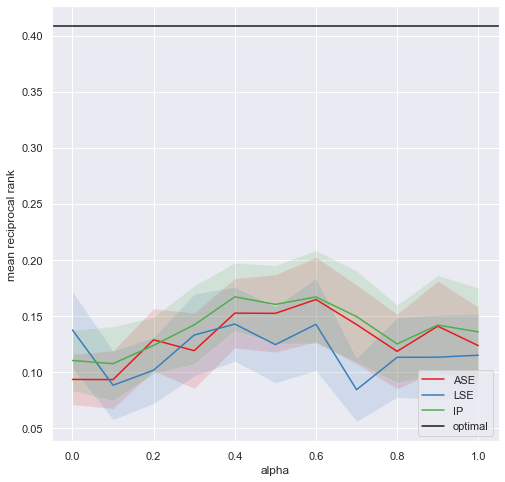

In [45]:
# mmrs_by_alpha = np.zeros((len(alphas), mc_its, J+1))
# alpha_hats_by_alpha = np.zeros((len(alphas), mc_its))

# for i, alpha in enumerate(tqdm(alphas)):
#     alpha_hats_by_alpha[i], mmrs_by_alpha[i] = monte_carlo(mc_its, n, d, embedding_functions, alpha, n_inds, acorn)

# Results

labels = ['ASE', 'LSE', 'IP']
mean_mmrs = np.mean(mmrs_by_alpha, axis=1)
std_err_mmrs = np.std(mmrs_by_alpha, axis=1, ddof=1) / np.sqrt(mc_its)

fig, ax = plt.subplots(1,1, figsize=(8,8))
c = sns.color_palette('Set1', n_colors=3)
for i in range(J+1):
    ax.plot(alphas, mean_mmrs[:, i], label = labels[i], c=c[i])
    ax.fill_between(alphas, 
        mean_mmrs[:, i] + 1.96*std_err_mmrs[:, i], 
        mean_mmrs[:, i] - 1.96*std_err_mmrs[:, i], 
        where=mean_mmrs[:, i] + 1.96*std_err_mmrs[:, i] >= mean_mmrs[:, i] - 1.96*std_err_mmrs[:, i], 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)

optimal = mean_reciprocal_rank(np.arange(n-1), np.arange(np.math.ceil(np.math.log(n))))
ax.axhline(y=optimal, c='k', label='optimal')
ax.set_xlabel('alpha')
ax.set_ylabel('mean reciprocal rank')
ax.legend()
    
# plt.savefig('figures/optimal-distance-2/nmc%in%id%i_ASELSEIP_alpha0to1.png'%(mc_its, n, d))

In [16]:
np.random.seed(1)
mc_its=100
n=200
d=2
X = generate_latent_positions(n, d)
embedding_functions = [graspy.embed.AdjacencySpectralEmbed(n_components=2).fit_transform,
                        graspy.embed.LaplacianSpectralEmbed(n_components=2).fit_transform]
covariance_functions = [ASE_covariance, LSE_covariance]
J = len(embedding_functions)
h=0.1
alphas = np.arange(0,1+h,step=h)
n_inds = np.log
acorn=2

mmrs_by_alpha = np.zeros((len(alphas), mc_its, J+1))
alpha_hats_by_alpha = np.zeros((len(alphas), mc_its))

for i, alpha in enumerate(tqdm(alphas)):
    alpha_hats_by_alpha[i], mmrs_by_alpha[i] = monte_carlo(mc_its, X, embedding_functions, covariance_functions, alpha, n_inds, acorn)

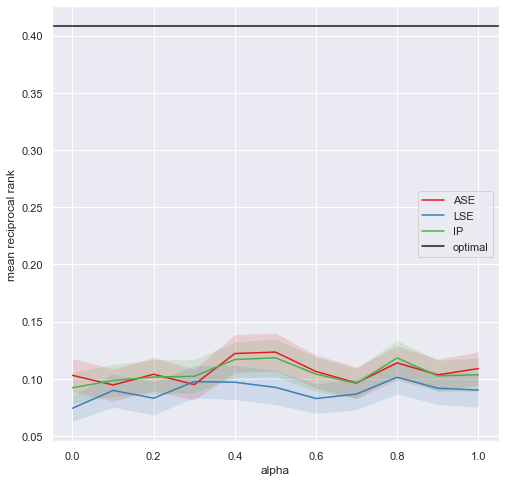

In [17]:
# mmrs_by_alpha = np.zeros((len(alphas), mc_its, J+1))
# alpha_hats_by_alpha = np.zeros((len(alphas), mc_its))

# for i, alpha in enumerate(tqdm(alphas)):
#     alpha_hats_by_alpha[i], mmrs_by_alpha[i] = monte_carlo(mc_its, n, d, embedding_functions, alpha, n_inds, acorn)

# Results

labels = ['ASE', 'LSE', 'IP']
mean_mmrs = np.mean(mmrs_by_alpha, axis=1)
std_err_mmrs = np.std(mmrs_by_alpha, axis=1, ddof=1) / np.sqrt(mc_its)

fig, ax = plt.subplots(1,1, figsize=(8,8))
c = sns.color_palette('Set1', n_colors=3)
for i in range(J+1):
    ax.plot(alphas, mean_mmrs[:, i], label = labels[i], c=c[i])
    ax.fill_between(alphas, 
        mean_mmrs[:, i] + 1.96*std_err_mmrs[:, i], 
        mean_mmrs[:, i] - 1.96*std_err_mmrs[:, i], 
        where=mean_mmrs[:, i] + 1.96*std_err_mmrs[:, i] >= mean_mmrs[:, i] - 1.96*std_err_mmrs[:, i], 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)

optimal = mean_reciprocal_rank(np.arange(n-1), np.arange(np.math.ceil(np.math.log(n))))
ax.axhline(y=optimal, c='k', label='optimal')
ax.set_xlabel('alpha')
ax.set_ylabel('mean reciprocal rank')
ax.legend()
    
plt.savefig('figures/optimal-distance-2/nmc%in%id%i_ASELSEIP_alpha0to1.png'%(mc_its, n, d))